In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import sys
sys.path.insert(0, "..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import datasets

## Minst

In [4]:
class Layer(object):

    def forward(self, x):
        pass

    def backward(self, dy):
        pass

    def update(self, lr=0.1):
        pass

In [5]:
class LinearLayer(Layer):

    def __init__(self, input, output) -> None:
        self.w = np.random.normal(
            loc=0.0,
            scale=pow(input, -0.5),
            size=(input, output)
        )
        self.dw = self.w * 0.1

    def forward(self, x):
        self.x = x
        y = np.dot(x, self.w)
        return y

    def backward(self, dy):
        dx = np.dot(dy, self.w.T)
        if dy.ndim == 1:
            self.dw = np.dot(self.x.reshape(-1, 1), dy.reshape(1, -1))
        else:
            self.dw = np.dot(self.x.T, dy)

        return dx

    def update(self, lr=0.1):
        self.w -= lr * self.dw

In [6]:
class SigmoidLayer(Layer):

    def forward(self, x):
        # scipy.special.expit(x)
        self.y = 1 / (1 + np.exp(-x))
        return self.y

    def backward(self, dy):
        dx = dy * (1.0 - self.y) * self.y
        return dx

## 均方误差

In [7]:
import sympy

In [8]:
x, t = sympy.symbols("x, t")

f =  ((x - t) ** 2) / 2
f

(-t + x)**2/2

In [9]:
sympy.diff(f, x).simplify()

-t + x

In [10]:
class MeanSquaredError(Layer):
    def forward(self, x, t):
        self.x = x
        self.t = t
        y = 0.5 * np.sum((x - t) ** 2)
        return y

    def backward(self, dy):
        dz = (self.x - self.t) * dy
        return dz

In [11]:
class NeuralNetwork(object):

    def __init__(self, input, hidden, output) -> None:
        self.layers = [
            LinearLayer(input, hidden),
            SigmoidLayer(),
            LinearLayer(hidden, output),
            SigmoidLayer(),
        ]

        self.loss_function = MeanSquaredError()

    def forward(self, x: np.ndarray):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self, y, t):
        err = self.loss_function.forward(y, t)
        return err

    def dloss(self):
        dloss = self.loss_function.backward(1)
        return dloss

    def backward(self, dy):
        for layer in self.layers[::-1]:
            dy = layer.backward(dy)
        return dy

    def update(self, lr=0.1):
        for layer in self.layers[::-1]:
            layer.update(lr)

In [12]:
x = np.array([
    [0.01, 0.01],
    [0.01, 0.99],
    [0.99, 0.01],
    [0.99, 0.99],
])
t = np.array([
    [0.45, 0.21],
    [0.01, 0.32],
    [0.50, 0.77],
    [0.17, 0.87],
])

In [13]:
np.seterr(all='ignore')

net = NeuralNetwork(2, 30, 2)

epoch = 2000

loss_list = []
acc_list = []

bar = tqdm(range(epoch))

for e in bar:
    y = net.forward(x)

    r = np.argmax(y, axis=1)

    total = x.shape[0]
    right = np.sum(r == np.argmax(t, axis=1))

    loss = net.loss(y, t)
    dloss = net.dloss()

    dx = net.backward(dloss)

    net.update()

    acc = right / total * 100
    loss_list.append(loss)
    acc_list.append(acc)
    bar.set_postfix(dict(loss=f"{loss:0.3}", acc=f"{acc:03}%"))

100%|██████████| 2000/2000 [00:03<00:00, 622.41it/s, loss=0.00336, acc=100.0%]


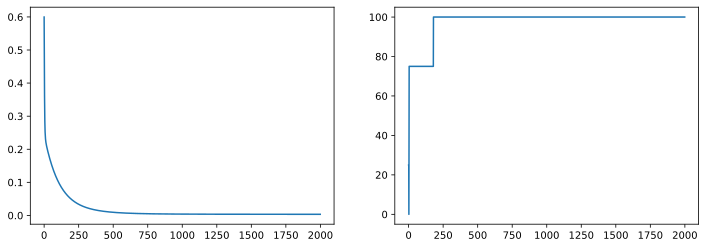

In [14]:
fig = plt.figure(figsize=(12, 4))
axes = fig.add_subplot(1, 2, 1)
axes.plot(loss_list, label='loss')
axes = fig.add_subplot(1, 2, 2)
axes.plot(acc_list, label='accuracy')
plt.show()

In [15]:
y = net.forward(x)
print("y:", y)
print('t:', t)

y: [[0.43284342 0.20184808]
 [0.07486723 0.32635158]
 [0.51661238 0.78011218]
 [0.13096082 0.85535694]]
t: [[0.45 0.21]
 [0.01 0.32]
 [0.5  0.77]
 [0.17 0.87]]


In [16]:
x_train, x_test, t_train, t_test = datasets.load_mnist()

In [17]:
net = NeuralNetwork(784, 47, 10)

In [18]:
np.seterr(all='ignore')

batch_size = 64
# train_size = (x_train.shape[0] // batch_size) * batch_size
train_size = batch_size * 100

x_train = x_train[0:train_size]
t_train = t_train[0:train_size]

epoch = 20

loss_list = []
acc_list = []

for e in range(epoch):

    bar = tqdm(range(int(train_size / batch_size)))

    bar.set_description(f'Epoch: {e}')

    indices = list(range(train_size))

    total = 0
    right = 0

    for _ in bar:
        if not indices:
            break

        batch_mask = np.random.choice(indices, batch_size, replace=False)
        for var in batch_mask:
            indices.remove(var)

        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        y = net.forward(x_batch)

        r = np.argmax(y, axis=1)
        total += x_batch.shape[0]
        right += np.sum(r == np.argmax(t_batch, axis=1))

        loss = net.loss(y, t_batch)
        dloss = net.dloss()
        dx = net.backward(dloss)
        net.update()

        acc = right / total * 100
        loss_list.append(loss)
        acc_list.append(acc)
        bar.set_postfix(dict(loss=f"{loss:0.3}", acc=f"{acc:0.3}%"))


Epoch: 19: 100%|██████████| 100/100 [00:02<00:00, 42.85it/s, loss=2.27, acc=97.8%]


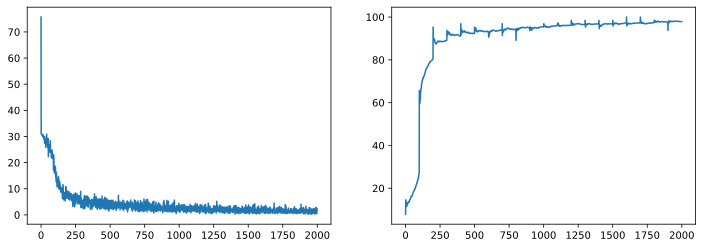

In [19]:
fig = plt.figure(figsize=(12, 4))
axes = fig.add_subplot(1, 2, 1)
axes.plot(loss_list, label='loss')
axes = fig.add_subplot(1, 2, 2)
axes.plot(acc_list, label='accuracy')
plt.show()

In [20]:
right = 0
total = 0

for i in range(x_test.shape[0]):
    x = x_test[i]
    t = t_test[i]
    y = net.forward(x)
    l = np.argmax(y)

    total += 1
    if l == np.argmax(t):
        right += 1

print("accuracy:", right / total * 100)


accuracy: 93.58857142857143
